# (Pre)processing Pipeline Ph1VALID (EMG)

## Data Management
- data collected during the experiment is stored in folders named for the subject id
- EMG data and the logfiles of Neurobs Presesntation were stored seperately

```
ph1valid_data\
│   
├───EMG_raw\
│   │
│   ├───VP01\
│   │   │  VP01_20160518.bdf
│   │
│   ├───VP02\
│   │   │  VP14_20160519.bdf
│   │ ...
│
├───Presentation_logfiles\
│   │
│   ├───VP01\
│   │   │  VP01_RP.tsv
│   │   │  VP01_TS_l.tsv
│   │   │  VP01_M_subjinfo.tsv
│   │   │  VP01_ValidExp.log
│   │ 
│   ├───VP02\
│      ...
│
└───Unipark_Export\
        data_project_575802_2016_06_10.csv
```

- Intermediate results are stored after each step of the processing pipeline:

```
ph1valid_out\
│   
├───EMG_preprocessed\
│   │
│   ├───VP01\
│   │   │  VP01_20160518.bdf
│   │
│   ├───VP02\
│   │   │  VP14_20160519.bdf
│   │ ...
│
├───subjmfiles\
│   │
│   ├───VP01\
│   │   │  VP01_RP.tsv
│   │   │  VP01_TS_l.tsv
│   │   │  VP01_M_subjinfo.tsv
│   │   │  VP01_ValidExp.log
│   │ 
│   ├───VP02\
│      ...
│
└───Grand_Averages\
        tlga_rp.mat
        tlga_ts.mat
```

- The 'subjmfile' of each subject contains all Information that has been gathered or calculated:
    - Block Order and letter-response matching
    - date of experimental procedure
    - all demographic and other information given by the subject during the experimental run
    - output of preprocessing (data quality, nr of trials, amplitudes, errors etc.)
    - output of classification (Omissions, False Positives, Response Times etc.)
    - results of the NEO-FFI survey
- can be loaded (as structure 'subjinfo') into the Matlab workspace with 'eval(<filename>)'

## Preprocessing

In [12]:
global ft_default;
ft_default.trackcallinfo = 'no';
ft_default.showcallinfo = 'no';
evalc('mydat = ph1valid01_prepro;');

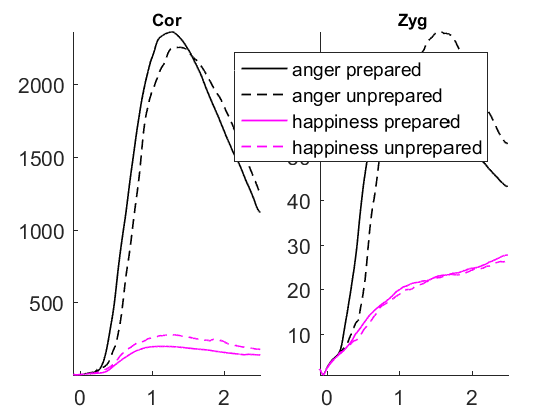

In [10]:

ph1valid03_timelock;

In [7]:
%edit 'functions/ph1valid01_prepro.m'

In [8]:
%%file functions/ph1valid01_prepro.m
function [ data, Info ] = ph1valid01_prepro( subjid, varargin )
%PH1VALID01_PREPRO basic EMG preprocessing
%   takes a subjid and preprocesses the corresponding bdf recording
%   inputs:
%   - subjid (e.g. 'VP07')
%   - cfg.sgm: segment begin/end (default [2 2.5])
%   - cfg.bsl1: baseline period for rejection of trials with early activity (default [-2 -1.8])
%   - cfg.bsl2: baseline period for actual classification of trials (default [-0.1 0])
%
%
%   returns
%       - fieldtrip data structure
%
%   also writes fieldtrip data structure to out-folder
%   and saves the additional information in the corresponding subject's
%   subjmfile
%   


%% parsing inputs
if exist('subjid','var') == 0
    warning('No subjid provided; using VP16 for testing purposes');
    subjid = 'VP16';
    warn = true;
else
    warn = false;
end;

[input, subjid] =  checkInputs(subjid, varargin{:});


%% checking Setup

SessionInfo = ph1valid_setup;

%% get rid of exluded subjects
excl_nodata = ['VP03';'VP07';'VP08'];

if ismember(subjid,excl_nodata,'rows')
    Info.emg_data = 'no';
    Info.nRpTrials = 0;
    Info.isExcluded = 'yes';
    ph1valid_writeToSubjmfile(Info, subjid);
    error('custom:no_data', 'no EMG data found for %s', subjid);
end;

%% reading data file and check if EMG data is there

try
    dataFile = ph1valid_validate(subjid);
catch
   Info.emg_data = 'no';
   Info.nRpTrials = 0;
   Info.isExcluded = 'yes';
   ph1valid_writeToSubjmfile(Info, subjid);
   return;
end;

Info.emg_data = 'yes';

%% Preprocessing (demean1, demean2, detrend, filter, segment, rectify, ...
[ data ] = basicPrepro(dataFile, input, SessionInfo.emgPreproDir, subjid);

%% collect some basic information on the dataset
conds = {'AN_prep' 'AN_unprep' 'HA_prep' 'HA_unprep';
        51 61 52 62;
        1 1 2 2};
    
% get thresholds and Amplitudes

[ Info ] = getThresholds(data{1}, Info, conds, '');

%% find errors (reactions ocurring prior to target stimulus)

[ Info, data{1} ] = getErrors(data{1}, Info, conds);

data{2}.trialinfo = data{1}.trialinfo;
data = data{2};
% second column data.trialinfo: trialtype
% 60 = early activity in correct channel
% 69 = early acitivity in incorrect channel


%% remove error trials from dataset
Info.cleanTrials = setdiff(1:size(data.trialinfo, 1),Info.allErrors);
cfg = [];
cfg.trials = Info.cleanTrials;

data = ft_selectdata(cfg, data);
data.cfg.event = data.cfg.previous.event;

%% recalculate thresholds
[ Info ] = getThresholds(data, Info, conds, 'clean');

Info.isExcluded = 'no';

while true
    try
        save(fullfile(SessionInfo.emgPreproDir, subjid, [subjid '_prepro.mat']), 'data');
        break;
    catch
        mkdir(fullfile(SessionInfo.emgPreproDir, subjid));
    end;
end;

ph1valid_writeToSubjmfile(Info, subjid);

if warn
    warning('No subjid provided; used VP16 for testing purposes.');
end;


function [ data ] = basicPrepro (dataFile, input, emgPreproDir, subjid)
Info.emg_data = 'yes';
hdr = ImportBDFHeader(dataFile);
Info.date = datetime([hdr.dataDate '_' hdr.dataTime],'InputFormat','dd.MM.yy_HH.mm.ss');

%define trials
cfg = [];                                   % create an empty variable called cfg
cfg.trialdef.prestim = input.sgm(1);                 % in seconds
cfg.trialdef.poststim = input.sgm(2);                  % in seconds
cfg.trialfun = 'trialfun_ph1valid';
cfg.dataset = dataFile;
try
    cfg = ft_definetrial(cfg);
catch ME
    %disp(ME);
    a = strsplit(ME.identifier, '_');
    Info.nRpTrials = str2double(a{2});
    Info.isExcluded = 'yes';
    ph1valid_writeToSubjmfile(Info, subjid);
    rethrow(ME);
end;

[ ~, lastid ] = lastwarn;

if length(lastid) < 4 
    Info.nRpTrials = 200;
    ph1valid_writeToSubjmfile(Info, subjid);
elseif strcmp(lastid(1:4),'cust')
    a = strsplit(lastid, '_');
    Info.nRpTrials = str2double(a{2});
    ph1valid_writeToSubjmfile(Info, subjid);
else
    Info.nRpTrials = 200;
    ph1valid_writeToSubjmfile(Info, subjid);
end;

%%% preprocess
% baseline correction, low pass filter (10Hz, order 2)
cfg.demean          = 'yes';
cfg.baselinewindow  = input.bsl1;
cfg.lpfilter        = 'yes';
cfg.lpfreq          = 10;
cfg.lpfiltord = 2; % for BVA (defaults) compatibility
data{1} = ft_preprocessing(cfg);
cfg.baselinewindow = input.bsl2;
data{2} = ft_preprocessing(cfg);

bipolar.labelorg  = {'EXG1', 'EXG2', 'EXG3', 'EXG4'};
bipolar.labelnew  = {'Cor', 'Zyg'};
bipolar.tra       = [
      +1 -1  0  0
       0  0 +1 -1
    ];

data = cellfun(@(x) ft_apply_montage(x, bipolar), data, 'UniformOutput', false);

for i = 1:length(data)
    data{i}.trial = cellfun(@abs,data{i}.trial, 'UniformOutput', false);
end;

function [ dataFile ] = ph1valid_validate( subjid )
%PH1VALID_VALIDATERP Checks Validity of RP segment in EMG data
%   returns file handle

p=inputParser;

validSubjid = @(x) validateattributes(x,{'char'},{'size',[1,4]});
p.addRequired('subjid',validSubjid);

p.parse(subjid);

global Sess;
    
if ~isempty(Sess);
    SessionInfo = Sess;
else %setup has not yet been called
    clear Sess;
    SessionInfo = ph1valid_setup;
end;

% get the folder
dataDir = fullfile(SessionInfo.emgRawDir, subjid);
assert(exist(dataDir, 'dir')==7,'custom:no_data', 'no such directory: %s', dataDir);

% get the file
fname = dir(fullfile(dataDir, '*.bdf'));
assert(~isempty(fname),'custom:no_data', 'No *.bdf file found in %s.', dataDir);

if length(fname) > 1
    warning('multiple *.bdf files found, caution advised'); %TODO: automatically concatenate the files
end;
[~,idx] = max([fname.bytes]);
fname = fname(idx).name;  % take the largest file
%if strcmp(subjid, 'VP01')
dataFile = fullfile(dataDir, fname);

function [input, subjid] =  checkInputs(subjid, varargin)

defSgm = [2 2.5];
defBsl1 = [-2 -1.8];
defBsl2 = [-0.1 0];
defReThreshold = true;

p=inputParser;

validSubjid = @(x) validateattributes(x,{'char'},{'size',[1,4]});
validRange = @(x) validateattributes(x,{'double'},{'size',[1,2]});
validBool = @(x) validateattributes(x, {'logical'});

p.addRequired('subjid', validSubjid);

p.addParameter('sgm',defSgm, validRange);
p.addParameter('bsl1',defBsl1, validRange);
p.addParameter('bsl2',defBsl2, validRange);
p.addParameter('reThreshold',defReThreshold, validBool);

p.parse(subjid, varargin{:});
input = p.Results;
subjid = input.subjid;


function [ Info ] = getThresholds(data, Info, conds, type)
% recalculate clean thresholds
for i = 1:size(conds,2)
    con = conds{1,i};
    chani = conds{3,i};
    trg = conds{2,i};
    indices = data.trialinfo == trg;
    curdat = data.trial(indices);
    amps = cellfun(@(x) max(x(chani,:)), curdat);
    Info.([con '_' type 'MaxAmp']) = max(amps);
    Info.([con '_' type 'MeanMaxAmp']) = mean(amps);
    Info.([con '_' type 'Threshold']) = 0.25*mean(amps);
end;

function [ Info, data ] = getErrors(data, Info, conds)
nErrors = 0;
ch_wrong = [conds{3,[3 4 1 2]}];
con_wrong = conds(1, [3 4 1 2]);
allErrors = cell(1,4);
for i = 1:size(conds, 2)
    con = conds{1,i};
    trg = conds{2,i};
    chani = conds{3,i};
    chani_o = ch_wrong(i);
    th = Info.([con '_Threshold']);
    th_o = Info.([con_wrong{i} '_Threshold']);
    indices = find(data.trialinfo == trg);
    curdat = data.trial(indices);
    curtime = data.time(indices);
    
    errorTrials = nan(80,1);
    k = 1;
    for j = 1:length(curdat)
        idx = find(curdat{j}(chani,:) >= th, 1);  % indices of 'hits': => threshold in correct channel
        idx_o = find(curdat{j}(chani_o,:) >=th_o,1); % indices of hits-in-wrong-channel: wrong emotions shown
        if ~isempty(idx_o) && (curtime{j}(idx_o) < 0) && (-0.5 < curtime{j}(idx_o))   % current trial is wrong
            errorTrials(k) = indices(j);
            data.trialinfo(indices(j),2) = 69;
            k = k +1;
        elseif ~isempty(idx) && (curtime{j}(idx) < 0) && (-0.5 < curtime{j}(idx))
            errorTrials(k) = indices(j);
            data.trialinfo(indices(j),2) = 60;
            k = k+1;
        else
            data.trialinfo(indices(j),2) = nan;
        end;
    end;
    errorTrials(isnan(errorTrials)) = [];
    Info.([con '_errorTrials']) = errorTrials.';
    Info.([con '_nErrorTrials']) = length(errorTrials);
    allErrors{i} = errorTrials';
    nErrors = nErrors + length(errorTrials);
end;
Info.nErrors = nErrors;
Info.allErrors = [allErrors{:}];

% function data = concatVP14 (input, SessionInfo)
% dataDir = fullfile(SessionInfo.emgRawDir, 'VP14');
% fname = dir(fullfile(dataDir, '*.bdf'));
% 
% dataFile = [];
% dataFile.A = fullfile(dataDir, fname(1).name);
% dataFile.B = fullfile(dataDir, fname(2).name);
% 
% dat.A = basicPrepro(dataFile.A, input);
% dat.B = basicPrepro(dataFile.B, input);
% 
% data = ft_appenddata([], dat.A, dat.B);


Created file 'C:\Users\chdan\cd\Ph1VALID-EMG\functions\ph1valid01_prepro.m'.


In [2]:
a = 6

a =

     6
